# Na jakie dane będziemy zwracać uwagę?

Ponieważ naszym zadaniem jest skonstruowanie systemu rekomendującego **produkty użytkownikom na podstawie ich sesji**,
będziemy potrzebowali danych użytkowników obecnych w systemie sklepu eSzoping, wraz z ich listą intreakcji.

---

### Dane użytkowników

Dane użytkowników zawarte są w pliku **users.jsonl**.

Pojedynczy rekord opisujący użytkownika składa się z następujących kolumn:
- id użytkownika w systemie
- imię użytkownika
- miasto zamieszkania
- adres zamieszkania

Przypuszczalnie, nie wszystkie informacje zawarte w rekordach będą dla nas użyteczne. Dalsza analiza oceni przydatność poszczególnych atrybutów.

---

### Dane produktów

Dane związane z produktami zawarte są w pliku **products.jsonl**.

Pojedynczy rekord opisujący produkt składa się z następujących kolumn:
- id produktu w systemie
- nazwa produktu
- kategoria przynależności produktu
- cena produktu
- ocena produktu

Przypuszczalnie, nie wszystkie informacje zawarte w rekordach będą dla nas użyteczne. Dalsza analiza oceni przydatność poszczególnych atrybutów.

---


### Dane sesji

Dane łączące użytkowników z produktami zawarte są w pliku **sessions.jsonl**.
Plik ten zawiera rekordy opisujące aktywności użytkowników w obrębie strony eSzoping.

Pojedynczy rekord opisujący akcję użytkownika w systemie składa się z następujących kolumn:
- id sesji w systemie
- punkt w czasie odbycia się aktywności
- id użytkownika którego dotyczy wydarzenie
- id produktu którego dotyczy wydarzenie
- typ wydarzenia
- informacja o oferowanej zniżce
- id dokonanego zakupu

Aby wydobyć "pełnię" informacji odnośnie sesji, będziemy musieli uwzględnić pliki opisujące **produkty i użytkowników** w analizie danych sesji.

Przypuszczalnie, nie wszystkie informacje zawarte w rekordach będą dla nas użyteczne. Dalsza analiza oceni przydatność poszczególnych atrybutów.

---

### Nieistotne dane

Dane, których nie użyjemy w trakcie analizy, to te zawarte w pliku **deliveries.jsonl**. Plik ten zawiera rekordy opisujące zdarzenia dowozu produktu do kupującego. Zakładamy, iż dane te są nieistotne z punktu widzenia interakcji użytkownika ze sklepem internetowym.

In [1]:
import pandas as pd
import seaborn as sns

# Used for verbose data presentation.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

usersDataPath = './data/users.jsonl'
productsDataPath = './data/products.jsonl'
sessionsDataPath = './data/sessions.jsonl'

usersDF = pd.read_json(usersDataPath, lines=True)
sessionsDF = pd.read_json(sessionsDataPath, lines=True)
productsDF = pd.read_json(productsDataPath, lines=True)

# Analiza samodzielnych danych

Teraz dokładnie przyjrzymy się danym które mogą być analizowane samodzielnie. Zbadamy typy ich atrybutów, rozkłady oraz podejmiemy pierwsze decyzje modelowania danych.

## Dane produktów

Aby mieć lepsze "poczucie" analizowanych danych, poniżej prezentujemy 10 pierwszych rekordów obecnych w dostarczonych danych.

In [2]:
productsDF.head(n=10)

,product_id,product_name,category_path,price,user_rating
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,4.740862
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,2048.50,1.564504
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,7639.00,3.520694
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,4.334193
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,4.496124
5,1006,Call of Duty 4 Modern Warfare (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,59.90,0.405119
6,1007,Dead Space 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,89.99,1.889997
7,1008,Tom Clancy&#39;s Rainbow Six Vegas (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,2.097467
8,1009,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69.00,0.304420
9,1010,BioShock 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,89.99,3.894822


Już z tych przykładowych danych możemy wyciągnąć kilka interesujących wniosków. Po pierwsze, ceny produktów mogę w sposób znaczący różnić się między sobą (58.97 kontra 7639.00). Po drugie, ocena produktu może mieć wartość poniżej 1 (przykład z 5 wiersza). Po trzecie, nazwa produktu wydaje się być zbędna w momencie posiadania jego identyfikatora (jest ona po prostu kolejnym unikatowym ciągiem znaków). Po czwarte, i to jest najabrdziej istotny wniosek, kolumna **category_path** zawiera informacją o kategorii produktu w formie "doprecyzowywania" tzn. kategorie rozdzielane są znakiem **;** a najistotniejsza kategoria umieszczona jest na samym początku napisu.

In [3]:
productsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
 4   user_rating    319 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 12.6+ KB


Widzimy, iż dane produktów nie zawierają żadnych brakujących wartości. 

Dane produktów zawierają dwie kolumny o typie napisowym (product_name oraz category_path), jedną o typie całkowitym (product_id) oraz dwie o typie zmiennoprzecinkowym (price i user_rating).

### Identyfikatory produktu

W celu lepszego zaznajomienia się z danymi opisującymi identyfikator produktu dokonujemy dalszej analizy kolumny **product_id**.

In [4]:
print('Max id of the product is: {}'.format(productsDF['product_id'].max()))
print('Min id of the product is: {}'.format(productsDF['product_id'].min()))
print('Disctinct id count is: {}'.format(productsDF['product_id'].nunique()))

Max id of the product is: 1319
Min id of the product is: 1001
Disctinct id count is: 319


Jak widzimy, minimalnym identyfikatorem produktu jest wartość **1001** a maksymalnym wartość **1319**. Ponadto wszystkie wartości pomiędzy **1001 a 1319** są osiągane dokładnie 1 raz.

### Nazwy produktu

Następnie analizie poddamy kolumnę opisującą nazwę produktu **product_name**.

In [5]:
print('Distinct name count is: {}'.format(productsDF['product_name'].nunique()))

Distinct name count is: 319


Widzimy, iż w naszych danych nie występują produkty o tych samych nazwach.

### Scieżka kategorii

Teraz analizie poddamy kolumnę opisującą scieżkę kategorii produktu **category_path**. W tym celu przyjrzymy się dostępnym ścieżkom kategorii oraz liczności każdej z nich tzn. ile produktów należy do danej ścieżki.

In [6]:
print(productsDF['category_path'].drop_duplicates().reset_index(drop=True).sort_values().to_string(index=False))

                                    Gry i konsole;Gry komputerowe
                    Gry i konsole;Gry na konsole;Gry PlayStation3
                        Gry i konsole;Gry na konsole;Gry Xbox 360
   Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne
                                  Komputery;Monitory;Monitory LCD
                            Komputery;Tablety i akcesoria;Tablety
                                       Sprzęt RTV;Audio;Słuchawki
         Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4
                                 Sprzęt RTV;Video;Odtwarzacze DVD
               Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV
               Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące
  Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe
                          Telefony i akcesoria;Telefony komórkowe
                        Telefony i akcesoria;Telefony stacjonarne


Zauważamy, że ścieżki kategorii tworzą hierarchię. Każda kategoria ma swój korzeń, który jest rozwijany poprzez ewentualne dopisywanie nowych podkategorii.

In [7]:
productsDF.groupby('category_path')['product_id'].count().sort_values(ascending=False)

category_path
Gry i konsole;Gry komputerowe                                        202
Gry i konsole;Gry na konsole;Gry Xbox 360                             32
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                    30
Komputery;Monitory;Monitory LCD                                       17
Gry i konsole;Gry na konsole;Gry PlayStation3                          9
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne         9
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące      5
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe        4
Komputery;Tablety i akcesoria;Tablety                                  2
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4               2
Sprzęt RTV;Video;Odtwarzacze DVD                                       2
Telefony i akcesoria;Telefony komórkowe                                2
Sprzęt RTV;Audio;Słuchawki                                             1
Sprzęt RTV;Video;Telewizory i akcesor

Powyższy wynik ukazuje nam, że liczba produktów w kategoriach nie jest rozłożona w sposób równomierny. Niektóre kategorie posiadają jedynie jeden zakwalifikowany produkt, podczas gdy inne zawierają ich aż kilkadziesiąt lub kilkaset. Proponowanym rozwiązaniem będzie zmieniejszenie liczby dostępnych kategorii poprzez rzutowanie danych na odpowiedni korzeń hierarchi kategorii. 

Poprzez rzutowanie moglibyśmy otrzymać następujące wyniki:
- "Gry komputerowe": 202
- "Gry na konsole": 41 (Xbox and PS3)
- "Sprzęt RTV": 36
- "Komputery": 28
- "Telefony i akcesoria": 12

Liczba i liczność wytworzonych kategorii wydaje się być zadowalająca na ten moment.

In [8]:
separator = ';'
newGroups = ['Gry komputerowe', 'Gry na konsole', 'Sprzęt RTV', 'Komputery', 'Telefony i akcesoria']

def castCategoryPath(categoryPath):
    categories = categoryPath.split(separator)
    foundGroups = [group for group in newGroups if group in categories]
    if len(foundGroups) != 1:
        raise RuntimeError('wrong group cast: {}'.format(foundGroups))
    return foundGroups[0]

transformed = productsDF['category_path'].apply(castCategoryPath)
print(transformed.value_counts())

Gry komputerowe         202
Gry na konsole           41
Sprzęt RTV               36
Komputery                28
Telefony i akcesoria     12
Name: category_path, dtype: int64


### Cena produktu

Poniżej przedstawiamy histogram prezentujący rozkład wartości cen zawartych w kolumnie **price**.

Max price is: 7639.0
Min price is: 1.0


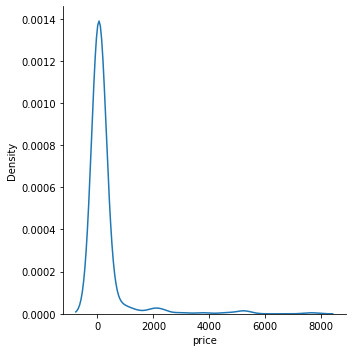

In [9]:
print('Max price is: {}'.format(productsDF['price'].max()))
print('Min price is: {}'.format(productsDF['price'].min()))

sns.displot(data=productsDF, x="price", kind="kde")

<AxesSubplot:xlabel='price'>

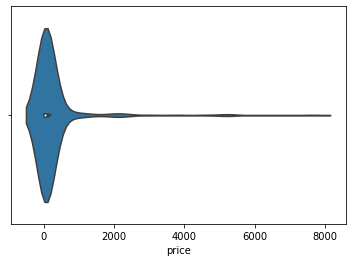

In [10]:
sns.violinplot(data=productsDF, x='price')

Widzimy, że zdecydowana większość cen mieści się w poniżej kwoty 100. Niestety, wartości odstające zakłócają wygląd wykresów. Decydujemy się rozbić produkty na tańsze i droższe. Jak punkt podziału przyjmujemy wartość 100. 

Cheap products amount is: 247
Expensie products amount is: 72


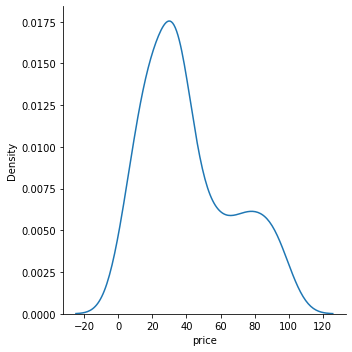

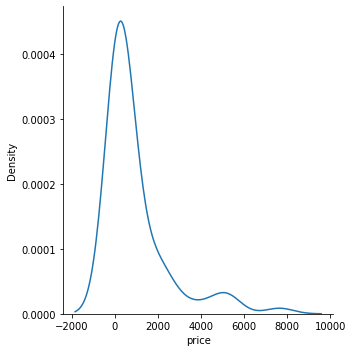

In [11]:
threshold = 100

cheapProducts = (productsDF.loc[productsDF['price'] < threshold], 'Cheap')
expensiveProducts = (productsDF.loc[productsDF['price'] >= threshold], 'Expensie')

productsSplit = [cheapProducts, expensiveProducts]

for ps in productsSplit:
    print('{} products amount is: {}'.format(ps[1], ps[0]['price'].count()))
    sns.displot(data=ps[0], x="price", kind="kde")

Jak widzimy, wartości zmiennej opisującej ceny produktu nie są rozłożone w sposób równomierny. Przypominają jednak złożenia kilku rozkładów normalnych których wartości oczekiwane i wariancje są różne. Interesujące wydają nam się również produkty z ceną 1.0. Postanawiamy przyjrzeć się rekordom z taką ceną.

In [12]:
productsDF.loc[productsDF["price"] == productsDF["price"].min()]

,product_id,product_name,category_path,price,user_rating
140,1141,Król Futbolu Piłkarski Quiz (PC),Gry i konsole;Gry komputerowe,1.0,3.462897
192,1193,Heroes Over Europe (PC),Gry i konsole;Gry komputerowe,1.0,4.549431
271,1272,The Ball (PC),Gry i konsole;Gry komputerowe,1.0,2.286441


Powyższe pozycje choć zastanawiające są możliwe. W celu weryfikacji poparwności tych danych konieczne jest zapytanie przedstawiciela firmy eSzoping.

### Ocena produktu

Poniżej prezentujemy wykres opisujący rozkład wartości zmiennych opisujących opinie o produkcie zawartych w kolumnie **user_rating**.

Max rating is: 4.993596217584222
Min rating is: 0.013904725430070002


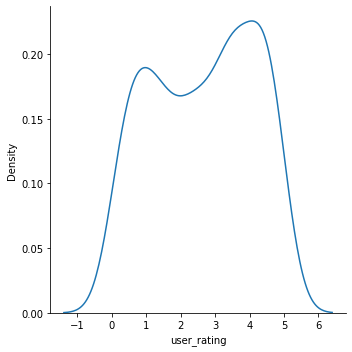

In [13]:
print('Max rating is: {}'.format(productsDF['user_rating'].max()))
print('Min rating is: {}'.format(productsDF['user_rating'].min()))

sns.displot(data=productsDF, x='user_rating', kind='kde')

Jak widać, opinie o produktach rozłożone są w sposób bardziej równomierny niż ceny produktów. Ponadto, wszystkie wartości z kolumny **user_rating** zawarte są w przedziale (0,5).

## Dane użytkowników

Podobnie jak w przypadku analizy danych o produktach, przyjrzyjmy się przykładowym wpisom w dostępnych danych:

In [14]:
usersDF.head(n=10)

,user_id,name,city,street
0,102,Angelika Gasik,Warszawa,al. Kamienna 87
1,103,Jakub Nickel,Szczecin,ul. Szpitalna 638
2,104,Emil Żuchowicz,Poznań,ulica Dolna 26
3,105,Gustaw Pośnik,Wrocław,ul. Osiedlowa 23/03
4,106,Sylwia Chuchla,Gdynia,aleja Krakowska 84/76
5,107,Grzegorz Machoń,Kraków,aleja Olchowa 28/90
6,108,Artur Doktor,Szczecin,pl. Handlowa 69/04
7,109,Nikodem Pyć,Radom,pl. Wojska Polskiego 404
8,110,Krystian Lesner,Szczecin,pl. Liliowa 708
9,111,Klara Szumiec,Gdynia,aleja Grabowa 92


Widzimy, że praktycznie wszystkie kolumny posiadają typ napisowy (**name, city, street**). Ponadto, kolumna **street** w rzeczywistości zawiera adres użykownika, a nie ulicę na której mieszka. Pozostałe kolumny wydają się być standardowe w kontekście zawieranych danych.

In [15]:
usersDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  200 non-null    int64 
 1   name     200 non-null    object
 2   city     200 non-null    object
 3   street   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


Widzimy, że dane użytkowników nie zawierają żadnych brakujących wartości. Wszystkie wpisy są kompletne.

### Identyfikator użytkownika

Teraz przyjrzymy się wartościom zawartym w kolumnie **user_id**. Interesuje nas, czy wszystkie wartości są unikalne. Ponadto dobrze byłoby znać zakres identyfikatorów, oraz czy jest on w pełni zapełniony.

In [16]:
print('Max user id is: {}'.format(usersDF['user_id'].max()))
print('Min user id is: {}'.format(usersDF['user_id'].min()))
print('Unique identifiers number is: {}'.format(usersDF['user_id'].nunique()))

Max user id is: 301
Min user id is: 102
Unique identifiers number is: 200


Z powyższych wyników wnioskujemy, że zakres identyfikatorów wynosi [102, 301] Ponadto, każda wartość w tym zakresie przyjmowana jest dokładnie jeden raz.

### Imię użytkownika

Następną kolumną, jaką poddamy dalszej analizie, jest ta zawierająca informacje o imieniu użytkownika. Jesteśmy zainteresowani, czy w dostępnych danych istnieje duplikacja użytkownika (różne identyfikatory ale to samo imię i nazwisko).

In [17]:
print('Unique name count is: {}'.format(usersDF['name'].nunique()))

Unique name count is: 200


Jak widać, wszystkie imiona użytkowników są unikatowe. Dzięki temu, jesteśmy w stanie stwierdzić, że w zbiorze danych nie występują potencjalne anomalie. Poza tym zakładamy, że kolumna o nazwie **name** nie wnosi żadnych nowych informacji do modelu i rozwiązywanego zagadnienia. 

### Miasto zamieszkania

Kolumna zawierająca miasto zamieszkania użytkownika (zakładamy, że jest to miejsce zamieszkania, jednak nie mamy tutaj żadnej pewności co do tego) wydaje się nieść potencjalnie wiele przydatnych informacji. Przede wszystkim dzięki niej jesteśmy w stanie stwierdzić, czy zbiór użytkowników na których operujemy, jest reprezentatywny. Ponadto potencjalnie może zachodzić korelacja pomiędzy miastem zamieszkania a zainteresowaniem pewnymi produktami przez użytkowników. Poniżej prezentujemy histogram z uzyskanymi wynikami.

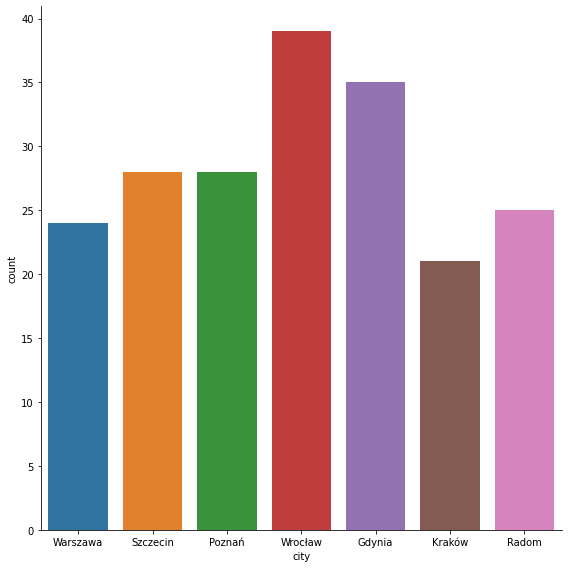

In [18]:
sns.catplot(data=usersDF, kind='count', x='city', height=8)

Z powyższego histogramu widzimy, iż pomimo pewnych nieregularności, dane są rozłożone dość równomiernie. Dzięki temu, jesteśmy w stanie stwierdzić, że dane na których pracujemy, są reprezentatywne

### Adres zamieszkania

Ostatnią kolumną do przeanalizowania jest ta zawierająca dane o adresach zamieszkania użytkowników. Zakładamy, iż prawdopodobnie kolumna to nie będzie dla nas w żaden sposób informatywna. Tym nie mniej, jesteśmy zainteresowani, czy w danych nie występuje duplikacja adresu.

In [19]:
print('Unique address count is: {}'.format(usersDF['street'].nunique()))

Unique address count is: 200


Jak widać, wszystkie adresu są unikatowe.

## Dane sesji

Przyjrzyjmy się nieco bliżej danym sesji.

In [20]:
sessionsDF.head(10)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-05-13 06:07:09,102,1317,VIEW_PRODUCT,0,NaN
1,125,2021-09-11 01:25:08,102,1170,VIEW_PRODUCT,0,NaN
2,125,2021-09-11 01:29:38,102,1055,VIEW_PRODUCT,0,NaN
3,125,2021-09-11 01:30:44,102,1053,VIEW_PRODUCT,0,NaN
4,125,2021-09-11 01:33:50,102,1060,VIEW_PRODUCT,0,NaN
5,125,2021-09-11 01:38:20,102,1048,VIEW_PRODUCT,0,NaN
6,125,2021-09-11 01:39:58,102,1011,VIEW_PRODUCT,0,NaN
7,125,2021-09-11 01:44:10,102,1098,VIEW_PRODUCT,0,NaN
8,125,2021-09-11 01:47:32,102,1055,VIEW_PRODUCT,0,NaN
9,125,2021-09-11 01:52:05,102,1053,VIEW_PRODUCT,0,NaN


Zgodnie ze zdrowym rozsądkiem dane sesji nie zawierają bezpośrednio wpisów danych użytkonika i produków, a jedynie ich unikalne identyfikatory.  
Nie stanowi to dla nasz żadnego problemu, gdyż pozostałe dane posiadają odpowiadajace klucze po których możemy połączyć je wszytskie w jedną tabelę.  
W tej sekcji postanowiliśmy odpowiedzieć sobie na kilka pytań istotnych z punktu widzenia zadania:
- Czy istnieje użytkownik nie posiadajacy żadnej sesji?
- Czy istnieje produkt, który nie został przez nikogo wyswietlony?
- Czy dane użytkowników i produktów są pełne, tj. czy w danych sesji jest produkt bądź użtkownik, który nie widnieje w innych dostarczonych danych.

Przy łączeniu danych wykorzystaliśmy **outer join** by wszelkie braki były proste do wychwycenia.

In [21]:
# Use outer join in order to keep all values from data frames.
mergedDF = pd.merge(sessionsDF, usersDF, how='outer', on='user_id')
mergedDF = pd.merge(mergedDF, productsDF, how='outer', on='product_id')

print(sessionsDF.shape[0] == mergedDF.shape[0])
mergedDF.info()

True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125146 entries, 0 to 125145
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   session_id        125146 non-null  int64         
 1   timestamp         125146 non-null  datetime64[ns]
 2   user_id           125146 non-null  int64         
 3   product_id        125146 non-null  int64         
 4   event_type        125146 non-null  object        
 5   offered_discount  125146 non-null  int64         
 6   purchase_id       10893 non-null   float64       
 7   name              125146 non-null  object        
 8   city              125146 non-null  object        
 9   street            125146 non-null  object        
 10  product_name      125146 non-null  object        
 11  category_path     125146 non-null  object        
 12  price             125146 non-null  float64       
 13  user_rating       125146 non-null  float64       
dtyp

Odpowiedzi na wszytskie powyzsze pytania są negatywne.  
Dodatkowo obsewrwujemy, że użytkownicy w większości przeglądają produkty, niż je kupują. Stosunek wynosi 114253:10893

Obszary którym przyjrzymy się nieco dokładniej w dalszej części:
- session_id - sparwdzenie ilości unikalnych sesji, sprawdzenie czy występują błędne dane (np. ujemne)
- timestamp - sprawdzenie przedziału czasu z jakiego pochodzą dane
- analiza danych sesji - jakie są najpopularniejsze kategorie, produkty itp.
- gęstość macierzy interakcji

### ID sesji
Poszukujemy błędów w atrybucie *session_id*, takich jak wartości ujemne i brak unikalności.

In [22]:
print(f"Minimum session id: {sessionsDF['session_id'].min()}")
print(f"Maximum session id: {sessionsDF['session_id'].max()}")
print(f"Number of unique sessions: {sessionsDF['session_id'].nunique()}")

Minimum session id: 124
Maximum session id: 21382
Number of unique sessions: 21259


Wartości w kolumnie *session_id* nie budzą zastzreżeń. Liczba 21259 unikalnych sesji wydaje się być wystarczajaco duża dla naszych potrzeb. 

### Sprawdzenie przedziału czasowego
Dla naszego problemu istotne jest sprawdzenie czy dane pochodzą z odpowednio długiego okresu. Uważamy, że minimalny przedział czasu pokryty przez dane powinien wynosić 1 rok. Dodatkowo zweryfikujemy czy w okresie pokrywanym przez dane nie ma dziur.

In [23]:
byDaySessionsDF = sessionsDF.groupby(pd.Grouper(key='timestamp', axis=0, freq='1D', sort=True))
print(f"Days count in data: {byDaySessionsDF.size().count()}")
print(f"first date: {byDaySessionsDF.count().head(1)}\nlast date: {byDaySessionsDF.count().tail(1)}")

Days count in data: 300
first date:             session_id  user_id  product_id  event_type  offered_discount  \
timestamp                                                                   
2021-01-01         431      431         431         431               431   

            purchase_id  
timestamp                
2021-01-01           36  
last date:             session_id  user_id  product_id  event_type  offered_discount  \
timestamp                                                                   
2021-10-27         304      304         304         304               304   

            purchase_id  
timestamp                
2021-10-27           23  


Dane pochodzą z 10 miesięcy, dokłądnie z okresu od 1.01.2021-27.10.2021, w danych nie występują przerwy. Oznacza to, że w danych nie występuje okres świąteczny, który jest istotnym okresem z punkty widzenia modelowania na potrzeby sklepu internetowego.  
Zamierzamy skontaktować się z reprezentantem firmy eSzoping w celu pozyskania zbioru danych z szerszego przedziału czasowego.

### Popularność produktów i kategorii
Poniżej sprawdzamy jak często każdy z produktów występuję w danych. Będzie to świadczyło o "popularności" produktów w sklepie.

count     319.00000
mean      392.30721
std       867.88119
min        52.00000
25%        76.00000
50%       118.00000
75%       301.00000
max      7237.00000
Name: product_id, dtype: float64

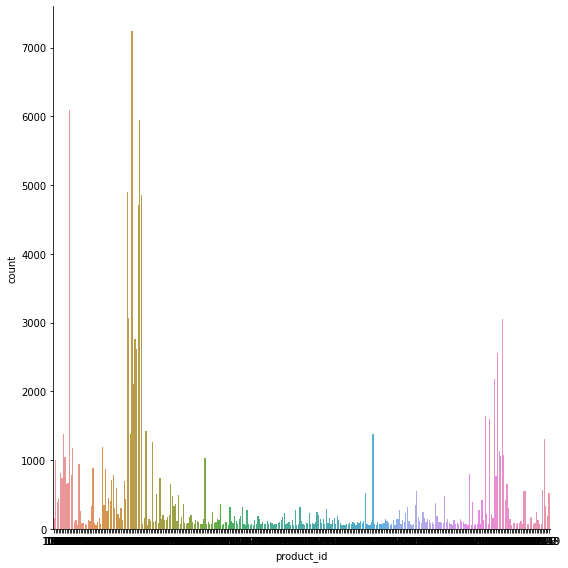

In [24]:
sns.catplot(data=sessionsDF, kind='count', x='product_id', height=8)
sessionsDF['product_id'].value_counts().describe()

Jak widać, w częstości interakcji z produktami istnieje duża dysproporcja. Widzimy, że jedynie niewielki odsetek produktów przyciąga znaczną uwagę użytkowników, podczas gdy większość produktów nie budzi większego zainteresowanie.  
Co istotne, każdy z produktów został obejrzany przez użytkownika. Minimalna liczba interakcji wynosi 52.  

Zainteresowało nas jakie dokładnie produkty są najpopularniejsze i do jakich kategorii należą. Za poziom odcięcia przyjęliśmy 95 percentyl.

count    16.000000
mean      2.909632
std       1.645935
min       0.131420
25%       1.775346
50%       3.011134
75%       4.426058
max       4.877668
Name: user_rating, dtype: float64


,product_id,product_name,category_path,price,user_rating
10,1011,BioShock Infinite (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,139.99,4.429294
47,1048,Gra o tron (PC),Gry i konsole;Gry komputerowe,63.49,0.131420
48,1049,Max Payne 3 (PC),Gry i konsole;Gry komputerowe,17.90,0.769084
50,1051,Spec Ops The Line (PC),Gry i konsole;Gry komputerowe,76.90,4.424979
51,1052,Duke Nukem Forever (PC),Gry i konsole;Gry komputerowe,78.90,0.684426
52,1053,Anno 2070 (PC),Gry i konsole;Gry komputerowe,42.90,3.553721
53,1054,Call of Duty 2 (PC),Gry i konsole;Gry komputerowe,32.99,2.468547
54,1055,Call of Duty Modern Warfare 3 (PC),Gry i konsole;Gry komputerowe,32.99,4.333934
55,1056,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99,2.062100
56,1057,Doom 3 (PC),Gry i konsole;Gry komputerowe,19.99,3.835961


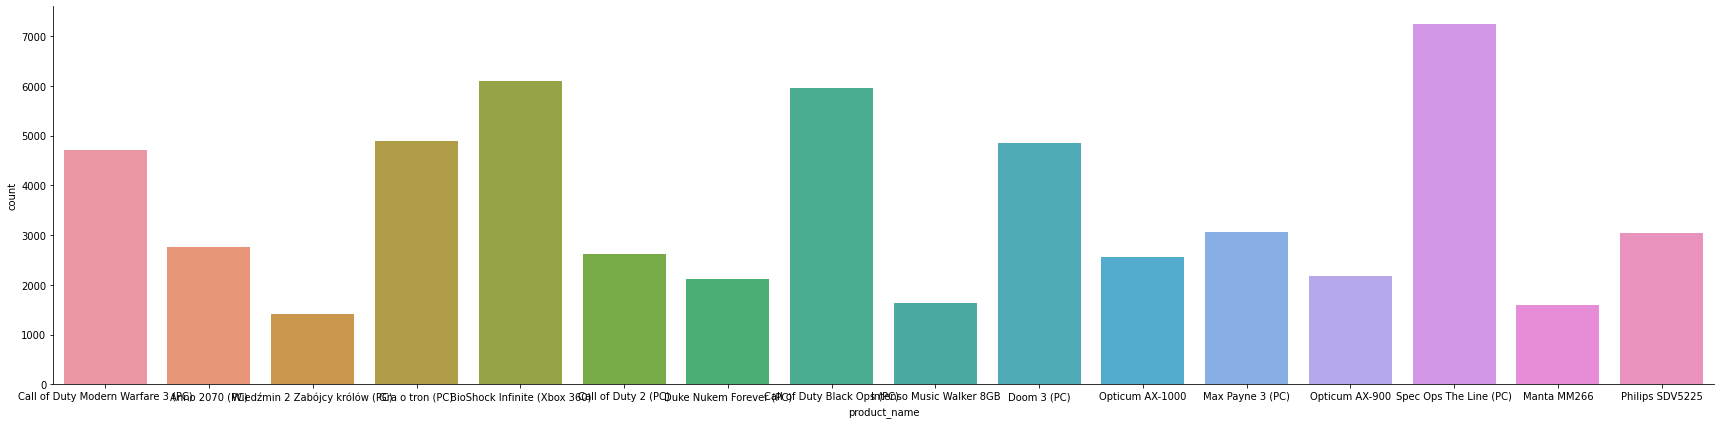

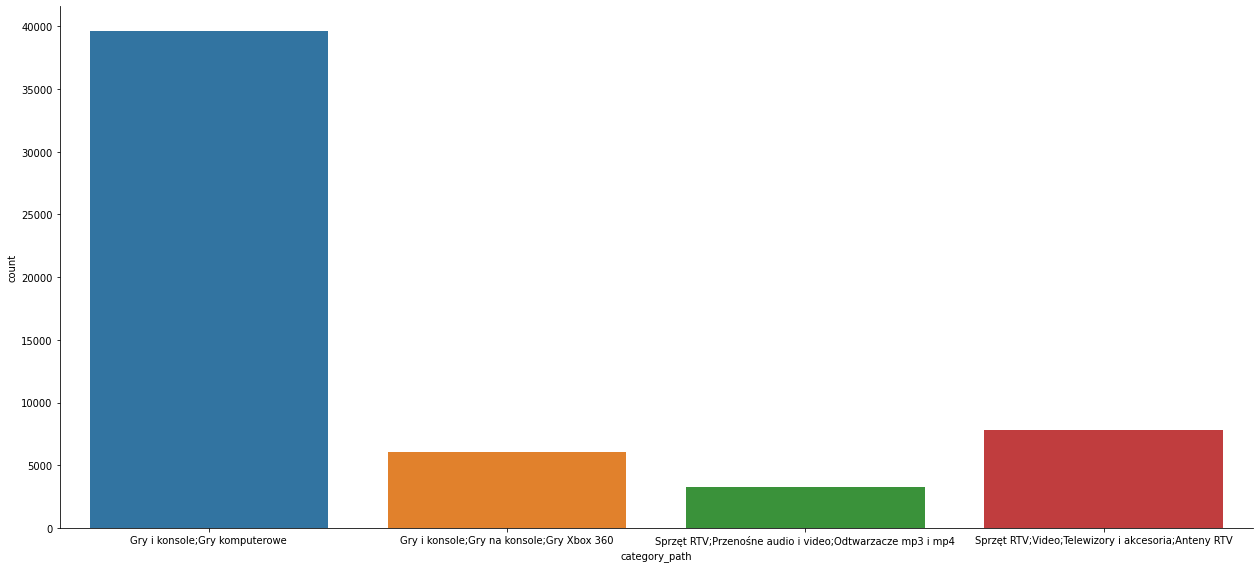

In [25]:
subSessionDF = sessionsDF.groupby('product_id').filter(lambda x : len(x) > sessionsDF['product_id'].value_counts().quantile(q=0.95)).copy()
subSessionProductDF = pd.merge(subSessionDF, productsDF, how='inner', on='product_id')
sns.catplot(data=subSessionProductDF, kind='count', x='product_name', height=6, aspect=4)
sns.catplot(data=subSessionProductDF, kind='count', x='category_path', height=8, aspect=2.2)
topProductsDF = productsDF.loc[productsDF['product_id'].isin(subSessionDF['product_id'].unique())]
print(topProductsDF['user_rating'].describe())
topProductsDF

Okazuje się, że najpopularniejszymi produktami w sklepie są **Gry komputero** komputerowe. Co ciekawe drugą najczęściej występującą kategorią są **Anteny RTV**.
Co ciekawe bardzo popularne są produkty o bardzo niskiej ocenie np. **Gra o tron (PC)**: ~5000 interakcji, ocena ~0.1.  
Wśród 16 najpopularniejszych produktów średnia ocena wynosi ~2.9 .

Spójrzmy teraz całosciowo na sesje i przeanalizujemy jakie są najczęściej oglądane i kupowane kategorie produktów. Ze względu, że "pełna kategoria" wprowadza zbyt dużą gradację,  
na potrzeby tej analizy kategorie zostały zredukowane do 5 (zaproponowanych wcześniej podczas analizy atrybutu *category_path*).  
Dane sesji podzieliśmy na dwa rozłączne podzbiory, w jednym znajduję się tylko obejrzane produkty, w drugim tylko produkty kupione (*event_type* odpowiednio *VIEW_PRODUCT* i *BUY_PRODUCT*).

Sessions with VIEW_PRODUCT event:
category_path
Gry komputerowe         62234
Gry na konsole          17366
Komputery               12446
Sprzęt RTV              17998
Telefony i akcesoria     4209
Name: session_id, dtype: int64

Sessions with BUY_PRODUCT event:
category_path
Gry komputerowe         3875
Gry na konsole          2770
Komputery                991
Sprzęt RTV              2709
Telefony i akcesoria     548
Name: session_id, dtype: int64


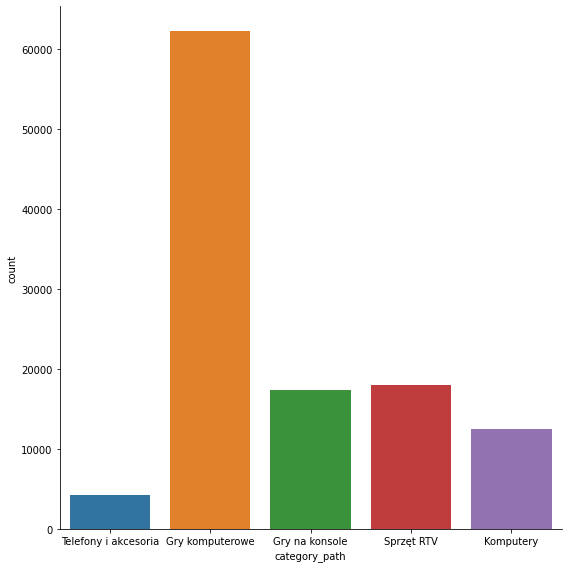

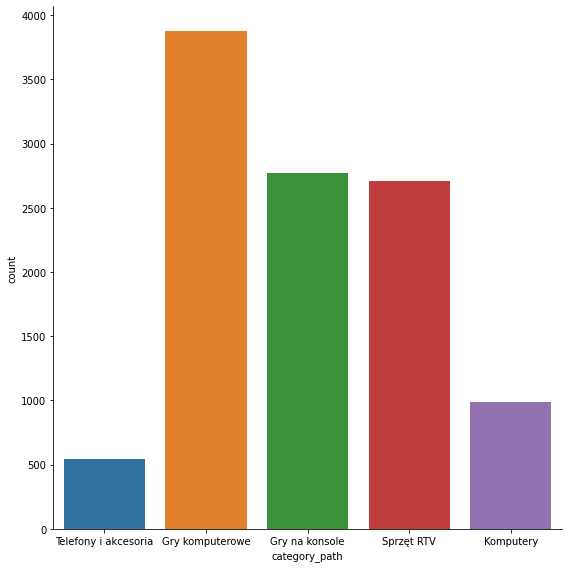

In [26]:
sessionProductDF = pd.merge(sessionsDF, productsDF, how='inner', on='product_id')
noBuySessionProductDF = sessionProductDF.drop(sessionProductDF.index[sessionProductDF['event_type'] == 'BUY_PRODUCT']).copy()
buySessionProductDF = sessionProductDF.dropna(subset=['purchase_id']).copy()

castNoBuySessionProductDF = noBuySessionProductDF.copy()
castNoBuySessionProductDF['category_path'] = noBuySessionProductDF['category_path'].apply(castCategoryPath)
sns.catplot(data=castNoBuySessionProductDF, kind='count', x='category_path', height=8)

print(f"Sessions with VIEW_PRODUCT event:\n{castNoBuySessionProductDF.groupby(['category_path'])['session_id'].count()}\n")

castBuySessionProductDF = buySessionProductDF.copy()
castBuySessionProductDF['category_path'] = buySessionProductDF['category_path'].apply(castCategoryPath)
sns.catplot(data=castBuySessionProductDF, kind='count', x='category_path', height=8)

print(f"Sessions with BUY_PRODUCT event:\n{castBuySessionProductDF.groupby(['category_path'])['session_id'].count()}")

Jak widzimy zarówno najczęściej oglądaną kategorią, jak i najchętniej kupowaną są **Gry komputerowe**, potem na równi **Gry na konsole** i **Sprzęt RTV**. Na trzeciej pozycji **Komputery** i najmniej popularna kategoria **Telefony i akcesoria**.   
Powyższe rezultaty były do przewidzenia, gdyż odpowiadają one liczności poszczególny grup. Najliczniejsze grupy będą statystycznie bardziej popularne od tych mnie licznych, nawet przy załozeniu losowej interakcji użytkownika.

## Współczynnik informacji wzajemnej

Informacyjność danych jest istotna dla każdego problemu modelowania. Dla nas szczególnie istotne jest sprawdzenie czy istnieje jakiś związek pomiędzy użytkownikiem, a przegladanymi produktami.  
W skali makroskopwej, tzn. czy użytkownik posiada jakieś indywidualne preferencje, możemy sprawdzić licząc współczynnik informacji wzajemnej dla atrybuty **user_id** i **category_path**.
Wspólczynnik policzyliśmy dla czterech formató danych:
- sesje oglądania produktu, ścieżka kategorii zrzutowana do 5 kategorii głównych
- sesje oglądania produktu, pełna ścieżka kategorii
- sesje kupowania produktu, ścieżka kategorii zrzutowana do 5 kategorii głównych
- sesje kupwoania produktu, pełna ścieżka kategorii

In [27]:
from sklearn import metrics

print(f"Mutual information score for user_id and casted category_path (view events): {metrics.mutual_info_score(castNoBuySessionProductDF['user_id'], castNoBuySessionProductDF['category_path'])}")
print(f"Mutual information score for user_id and category_path (view events): {metrics.mutual_info_score(noBuySessionProductDF['user_id'], noBuySessionProductDF['category_path'])}")

print(f"Mutual information score for user_id and casted category_path (buy events): {metrics.mutual_info_score(castBuySessionProductDF['user_id'], castBuySessionProductDF['category_path'])}")
print(f"Mutual information score for user_id and category_path (buy events): {metrics.mutual_info_score(buySessionProductDF['user_id'], buySessionProductDF['category_path'])}")

Mutual information score for user_id and casted category_path (view events): 0.012017914592724614
Mutual information score for user_id and category_path (view events): 0.03386461832079142
Mutual information score for user_id and casted category_path (buy events): 0.03665965936153716
Mutual information score for user_id and category_path (buy events): 0.12029254326184302


Współczynnik informacji wzajemnej ma bardzo niską wartość, tylko jeden współczynnik ma wartość powyżej 0.1 i wynosi on ~0.12. Co ciekawe okazuje się on być wyższy dla bardziej szczegółowych kategorii.  
Nie zmienia to faktu, że wskazuje on na arczej znikomą korelację tych dwóch atrybutów.

W obliczu tego rozczarowania postanowiliśmy sprawdzić czy może w danych zachodzi korelacja dla innej pary atrybutów. Naszym pomysłem było sprawdzenie czy istnieje zależność między ilością interakcji  
z produktem a jego oceną. Tym razem ze względu na ciągłość atyrbutów policzyliśmy korelację liniową, podobnie jak wcześniej policzyliśmy ją oddzielnie dla sesji przeglądania i zakupowych.

In [36]:
noBuySessionProductDF['user_rating'] = noBuySessionProductDF['user_rating'].apply(lambda x : round(x, 1))
noBuyProdCountSeries = noBuySessionProductDF.groupby(['product_id'])['user_id'].count().copy()
noBuyRatingSeries = noBuySessionProductDF.groupby(['product_id'])['user_rating'].unique().copy()
noBuyRatingSeries = noBuyRatingSeries.apply(lambda x : x[0])
print(f"Mutual information score for popularity of a product and user_rating (view events): {noBuyProdCountSeries.corr(noBuyRatingSeries)}")

buySessionProductDF['user_rating'] = buySessionProductDF['user_rating'].apply(lambda x : round(x, 1))
buyProdCountSeries = buySessionProductDF.groupby(['product_id'])['user_id'].count().copy()
buyRatingSeries = buySessionProductDF.groupby(['product_id'])['user_rating'].unique().copy()
buyRatingSeries = buyRatingSeries.apply(lambda x : x[0])
print(f"Mutual information score for popularity of a product and user_rating (buy events): {buyProdCountSeries.corr(buyRatingSeries)}")




Mutual information score for popularity of a product and user_rating (view events): 0.05366616059079891
Mutual information score for popularity of a product and user_rating (buy events): 0.21524332008730712


//ToDo wnioski
Okazuje się, że i wtym wypadku obserwujemy dość słabą korelację, dla zdarzeń przglądania jest ona bliska zeru. Wyniki powyższych dwóch ekperymentów zdają się sugerować jakiś problem z otrzymanymi danymi. Brakuje w nich spodziewanych/istotnych dla zadania zależności.

### Badanie gęstości macierzy interakcji
Postanowiliśmy sprawdzić również jak wyglada gęstość otrzymanych danych dla zadania predykcji. Utworzyliśmy macierz, której kolumny odpowiadają wszystkim produktom w ofercie, a wiersze poszczególnym użytkonikom.  
Jeżeli użytkownik wszedł w interakcje z danym produktem (obejrzał go lub kupił), w odpowidającej komórce będzie 1, w przeciwnym wypadku komórka pozostanie pusta. Dla tak utworzonej macierzy policzyliśmy gęstość.

In [29]:
df = sessionsDF.drop(columns=["session_id", "timestamp", "event_type", "offered_discount", "purchase_id"])
df["hit"] = 1
heatMapDF = pd.pivot_table(df, index="user_id", columns="product_id", values="hit")
print("Sparse matrix density: " + str((heatMapDF.size - heatMapDF.isna().sum().sum())/heatMapDF.size))


Sparse matrix density: 0.47782131661442007


Gęstość powyższej macierzy wynosi ~47,8% co jest wartością wystarczającą dla zadania rekomendacji.

# Podsumowanie
